In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

**Prepare** **the data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Data/archive.zip -d /content/Data

Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/2/23798_right.jpeg  
  inflating: /content/Data/2/23817_left.jpeg  
  inflating: /content/Data/2/23817_right.jpeg  
  inflating: /content/Data/2/23821_left.jpeg  
  inflating: /content/Data/2/23821_right.jpeg  
  inflating: /content/Data/2/23852_left.jpeg  
  inflating: /content/Data/2/23854_left.jpeg  
  inflating: /content/Data/2/23905_left.jpeg  
  inflating: /content/Data/2/23905_right.jpeg  
  inflating: /content/Data/2/23906_left.jpeg  
  inflating: /content/Data/2/23923_left.jpeg  
  inflating: /content/Data/2/23923_right.jpeg  
  inflating: /content/Data/2/23946_left.jpeg  
  inflating: /content/Data/2/23946_right.jpeg  
  inflating: /content/Data/2/23961_left.jpeg  
  inflating: /content/Data/2/23961_right.jpeg  
  inflating: /content/Data/2/23967_left.jpeg  
  inflating: /content/Data/2/23967_right.jpeg  
  inflating: /content/Data/2/239_left.jpeg  
  inflating: /content/Data/2/239_right.jpeg  
  in

In [ ]:
# checking how many files/samples are in each class
path = '../content/Data' 
for i in range(5):
  folder_path = path+'/'+str(i)
  num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
  print(num_files)

25810
2443
5292
873
708


Create the csv file

In [ ]:
img_names = []
img_labels = []
for i in range(5):
  folder_path = path+'/'+str(i)
  img_names_new = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  num_files = len(img_names_new)
  img_labels_new = [i] * num_files


  img_names += img_names_new
  img_labels += img_labels_new

print(len(img_names))
print(len(img_labels))

35126
35126


In [ ]:
df = pd.DataFrame(data={'img_name': img_names, 'label': img_labels})
df.to_csv('annotations.csv',index=False, header=True)

In [ ]:
# !rm '/content/train/0'

In [ ]:
"""
- creating the different sets with respective percentages
- NOTE: dataset is imbalanced, used a fixed size of 700 for each set
"""
# PREPROCESSING PARAMS
TRAIN_SIZE = 700
TEST_SIZE = 700
VALID_SIZE = 700

original_data_path = "../content/Data"
# train_pct = 0.7
# test_pct = 0.1
# valid_pct = 0.2

os.chdir("./")
if os.path.isdir("train/0") is False:
    # create folders for the sets
    os.mkdir("./train")
    # os.mkdir("./test")
    # os.mkdir("./valid")
    
    # move X number of instances from original set, to respective sets
    for i in range(0, 5):
        # path to inputs with different classes
        num_folder_path = f'{original_data_path}/{i}' 
        num_files_in_folder = len(os.listdir(num_folder_path))

        train_size = TRAIN_SIZE
        # test_size = TEST_SIZE
        # valid_size = VALID_SIZE
        
        # make classes within set
        os.mkdir(f'train/{i}')
        # os.mkdir(f'test/{i}')
        # os.mkdir(f'valid/{i}')
        
        # test_samples = random.sample(os.listdir(num_folder_path), test_size)
        # for file_name in test_samples:
        #     shutil.copy((f"../content/Data/{i}/{file_name}"), f'./test/{i}')

        train_samples = random.sample(os.listdir(num_folder_path), train_size)
        for file_name in train_samples:
            shutil.copy((f"../content/Data/{i}/{file_name}"), f'./train/{i}')
            
        # valid_samples = random.sample(os.listdir(num_folder_path), valid_size)
        # for file_name in valid_samples:
        #     shutil.copy((f"../content/Data/{i}/{file_name}"), f'./valid/{i}')

In [ ]:
import shutil
import os
  
  
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):
      
    # Path
    path = os.path.join(parent_folder, folder_name)
      
    # Create the folder
    # 'new_folder' in
    # parent_folder
    try: 
        # mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
    except OSError as error: 
        print(error)
  
# current folder path
current_folder = os.getcwd() 
  
# list of folders to be merged
list_dir = ['/content/train/0', '/content/train/1', '/content/train/2', '/content/train/3', '/content/train/4']
  
# enumerate on list_dir to get the 
# content of all the folders ans store 
# it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)
  
# folder in which all the content will
# be merged
merge_folder = "merge_folder"
  
# merge_folder path - current_folder 
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder) 
  
# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)
  
# loop through the list of folders
for sub_dir in content_list:
  
    # loop through the contents of the 
    # list of folders
    for contents in content_list[sub_dir]:
  
        # make the path of the content to move 
        path_to_content = sub_dir + "/" + contents  
  
        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content )
  
        # move the file
        shutil.move(dir_to_move, merge_folder_path)

In [ ]:
merge_path = '/content/merge_folder'
merged_imgs = [f for f in os.listdir(merge_path) if os.path.isfile(os.path.join(merge_path, f))]
# merged_imgs
filtered_df = df.loc[df.img_name.isin(merged_imgs)]
filtered_df.to_csv('filtered_annotations.csv',index=False, header=True)

Build the dataloader

In [ ]:
# for imgs, labels in data_loader:
#     print("Batch of images has shape: ",imgs.shape)
#     print("Batch of labels has shape: ", labels.shape)

Build dataloader

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class DiabeticRetinopathy(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)




Baseline CNN

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import torchvision.models as models

# class CNN(nn.Module):
#     def __init__(self, train_CNN=False, num_classes=5):
#         super(CNN, self).__init__()
#         self.train_CNN = train_CNN
#         self.inception = models.inception_v3(pretrained=True, aux_logits=False)
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, images):
#         features = self.inception(images)
#         return self.sigmoid(self.dropout(self.relu(features))).squeeze(1)


# kernel size is changed to 74
class DRClassifier(nn.Module):
    def __init__(self):
        super(DRClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding = 1)

        # self.lastcnn = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=74, stride=1, padding=0)

        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=5, kernel_size=74, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        #try softmax
        # x = F.relu(x)
        # return F.relu(x)
        return x
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block



model = DRClassifier()
device = ("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# experiment with SGD with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



DRClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 5, kernel_size=(74, 74), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
# import torch
# import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# # from Model import CNN
# # from Dataset import CatsAndDogsDataset
from tqdm import tqdm
# device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


Transform

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [ ]:
num_epochs = 50
learning_rate = 0.001
train_CNN = False
batch_size = 16
shuffle = True
pin_memory = True
num_workers = 1

In [ ]:
# torch.cuda.empty_cache()
# import gc
# del variables
# gc.collect()

In [ ]:
dataset = DiabeticRetinopathy("/content/merge_folder","filtered_annotations.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[2450,1050])
train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
# model = CNN().to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for name, param in model.inception.named_parameters():
#     if "fc.weight" in name or "fc.bias" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = train_CNN
def multi_acc(y_pred, y_test):
    # y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    # _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
    y_pred_tags = torch.argmax(y_pred, dim=1)
    # print('Predicted labels are:')
    # print(y_pred_tags) 
    # print('True labels are:')
    # print(y_test)  
    correct_pred = (y_pred_tags == y_test).float()
    # print(correct_pred)
    acc = correct_pred.sum() / len(correct_pred)
    # print('acc is'+str(acc))
    acc = torch.round(acc * 100)
    return acc
    

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

Model training

In [ ]:
print("Begin training.")
for e in tqdm(range(num_epochs)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()

        # y_train_pred = torch.argmax(y_train_pred, dim=1).float()
        # y_torch.unsqueeze(y_val_pred, 0)
        # print(len(y_train_pred))


        #print the shape to check the input size
        # print('Probs for each class in each batch:')
        # print(y_train_pred)
        # print('Targets are:')
        # print(y_train_batch)
        # print(' ')
        y_train_batch = y_train_batch.long()
        train_loss = criterion(y_train_pred, y_train_batch)


        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in validation_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()

            # y_val_pred = torch.unsqueeze(y_val_pred, 0)
            y_val_batch = y_val_batch.long()

            # print(y_val_pred)
            # print(y_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            # val_epoch_loss += train_loss.item()
            # val_epoch_acc += train_acc.item()
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validation_loader))

    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validation_loader))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validation_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(validation_loader):.3f}')


Begin training.


  2%|▏         | 1/50 [01:14<1:00:49, 74.48s/it]

Epoch 00: | Train Loss: 12.50466 | Val Loss: 1.60926 | Train Acc: 18.390| Val Acc: 20.909


  4%|▍         | 2/50 [02:28<59:16, 74.09s/it]  

Epoch 01: | Train Loss: 1.60975 | Val Loss: 1.61359 | Train Acc: 22.026| Val Acc: 23.773


  6%|▌         | 3/50 [03:42<57:55, 73.96s/it]

Epoch 02: | Train Loss: 1.61640 | Val Loss: 1.60964 | Train Acc: 21.545| Val Acc: 21.455


  8%|▊         | 4/50 [04:55<56:39, 73.91s/it]

Epoch 03: | Train Loss: 1.61027 | Val Loss: 1.60987 | Train Acc: 22.214| Val Acc: 19.803


 10%|█         | 5/50 [06:10<55:31, 74.04s/it]

Epoch 04: | Train Loss: 1.60922 | Val Loss: 1.61164 | Train Acc: 22.019| Val Acc: 21.000


 12%|█▏        | 6/50 [07:24<54:22, 74.14s/it]

Epoch 05: | Train Loss: 1.60447 | Val Loss: 1.61360 | Train Acc: 23.143| Val Acc: 20.712


 14%|█▍        | 7/50 [08:39<53:20, 74.43s/it]

Epoch 06: | Train Loss: 1.63763 | Val Loss: 1.61604 | Train Acc: 24.597| Val Acc: 21.076


 16%|█▌        | 8/50 [09:53<52:02, 74.35s/it]

Epoch 07: | Train Loss: 1.60344 | Val Loss: 1.60973 | Train Acc: 23.370| Val Acc: 21.727


 18%|█▊        | 9/50 [11:07<50:39, 74.14s/it]

Epoch 08: | Train Loss: 1.60341 | Val Loss: 1.62687 | Train Acc: 22.935| Val Acc: 20.970


 20%|██        | 10/50 [12:21<49:21, 74.03s/it]

Epoch 09: | Train Loss: 1.60638 | Val Loss: 1.62225 | Train Acc: 23.214| Val Acc: 21.788


 22%|██▏       | 11/50 [13:34<48:03, 73.93s/it]

Epoch 10: | Train Loss: 1.60019 | Val Loss: 1.60880 | Train Acc: 24.740| Val Acc: 22.500


 24%|██▍       | 12/50 [14:48<46:48, 73.90s/it]

Epoch 11: | Train Loss: 1.60134 | Val Loss: 1.61927 | Train Acc: 24.390| Val Acc: 22.727


 26%|██▌       | 13/50 [16:02<45:32, 73.86s/it]

Epoch 12: | Train Loss: 1.59864 | Val Loss: 1.61218 | Train Acc: 25.201| Val Acc: 21.333


 28%|██▊       | 14/50 [17:16<44:18, 73.85s/it]

Epoch 13: | Train Loss: 1.58883 | Val Loss: 1.63927 | Train Acc: 26.494| Val Acc: 21.758


 30%|███       | 15/50 [18:30<43:02, 73.80s/it]

Epoch 14: | Train Loss: 1.59025 | Val Loss: 1.61315 | Train Acc: 24.175| Val Acc: 25.197


 32%|███▏      | 16/50 [19:43<41:48, 73.77s/it]

Epoch 15: | Train Loss: 1.60029 | Val Loss: 1.61386 | Train Acc: 23.903| Val Acc: 21.227


 34%|███▍      | 17/50 [20:57<40:32, 73.70s/it]

Epoch 16: | Train Loss: 1.59350 | Val Loss: 1.61399 | Train Acc: 24.474| Val Acc: 22.864


 36%|███▌      | 18/50 [22:10<39:18, 73.71s/it]

Epoch 17: | Train Loss: 1.58852 | Val Loss: 1.61152 | Train Acc: 25.494| Val Acc: 22.530


 38%|███▊      | 19/50 [23:24<38:06, 73.75s/it]

Epoch 18: | Train Loss: 1.59758 | Val Loss: 1.61250 | Train Acc: 24.747| Val Acc: 22.606


 40%|████      | 20/50 [24:38<36:51, 73.73s/it]

Epoch 19: | Train Loss: 1.58692 | Val Loss: 1.61768 | Train Acc: 27.273| Val Acc: 21.727


 42%|████▏     | 21/50 [25:52<35:38, 73.74s/it]

Epoch 20: | Train Loss: 1.58857 | Val Loss: 1.62306 | Train Acc: 26.455| Val Acc: 23.091


 44%|████▍     | 22/50 [27:06<34:27, 73.82s/it]

Epoch 21: | Train Loss: 1.59260 | Val Loss: 1.61089 | Train Acc: 25.844| Val Acc: 24.667


 46%|████▌     | 23/50 [28:20<33:18, 74.02s/it]

Epoch 22: | Train Loss: 1.58669 | Val Loss: 1.60828 | Train Acc: 25.851| Val Acc: 23.955


 48%|████▊     | 24/50 [29:35<32:08, 74.17s/it]

Epoch 23: | Train Loss: 1.59000 | Val Loss: 1.62264 | Train Acc: 25.857| Val Acc: 22.879


 50%|█████     | 25/50 [30:49<30:53, 74.12s/it]

Epoch 24: | Train Loss: 1.58879 | Val Loss: 1.61845 | Train Acc: 26.201| Val Acc: 23.742


 52%|█████▏    | 26/50 [32:03<29:38, 74.09s/it]

Epoch 25: | Train Loss: 1.58339 | Val Loss: 1.60244 | Train Acc: 26.253| Val Acc: 22.924


 54%|█████▍    | 27/50 [33:17<28:24, 74.10s/it]

Epoch 26: | Train Loss: 1.58748 | Val Loss: 1.60518 | Train Acc: 25.032| Val Acc: 23.697


 56%|█████▌    | 28/50 [34:31<27:09, 74.08s/it]

Epoch 27: | Train Loss: 1.58494 | Val Loss: 1.61068 | Train Acc: 26.442| Val Acc: 22.561


 58%|█████▊    | 29/50 [35:45<25:52, 73.93s/it]

Epoch 28: | Train Loss: 1.58131 | Val Loss: 1.61507 | Train Acc: 27.344| Val Acc: 23.636


 60%|██████    | 30/50 [36:58<24:37, 73.86s/it]

Epoch 29: | Train Loss: 1.58540 | Val Loss: 1.63023 | Train Acc: 26.526| Val Acc: 20.924


 62%|██████▏   | 31/50 [38:12<23:24, 73.94s/it]

Epoch 30: | Train Loss: 1.57827 | Val Loss: 1.63354 | Train Acc: 27.273| Val Acc: 21.091


 64%|██████▍   | 32/50 [39:26<22:10, 73.90s/it]

Epoch 31: | Train Loss: 1.57654 | Val Loss: 1.64781 | Train Acc: 27.390| Val Acc: 23.818


 66%|██████▌   | 33/50 [40:40<20:55, 73.85s/it]

Epoch 32: | Train Loss: 1.57820 | Val Loss: 1.61810 | Train Acc: 27.084| Val Acc: 21.758


 68%|██████▊   | 34/50 [41:54<19:40, 73.78s/it]

Epoch 33: | Train Loss: 1.58383 | Val Loss: 1.62298 | Train Acc: 27.130| Val Acc: 22.212


 70%|███████   | 35/50 [43:07<18:27, 73.82s/it]

Epoch 34: | Train Loss: 1.57970 | Val Loss: 1.61397 | Train Acc: 26.981| Val Acc: 23.030


 72%|███████▏  | 36/50 [44:22<17:18, 74.18s/it]

Epoch 35: | Train Loss: 1.57705 | Val Loss: 1.64965 | Train Acc: 26.838| Val Acc: 21.788


 74%|███████▍  | 37/50 [45:37<16:06, 74.31s/it]

Epoch 36: | Train Loss: 1.57349 | Val Loss: 1.61446 | Train Acc: 28.429| Val Acc: 23.439


 76%|███████▌  | 38/50 [46:51<14:49, 74.11s/it]

Epoch 37: | Train Loss: 1.57927 | Val Loss: 1.62214 | Train Acc: 27.571| Val Acc: 24.424


 78%|███████▊  | 39/50 [48:05<13:34, 74.07s/it]

Epoch 38: | Train Loss: 1.57664 | Val Loss: 1.61727 | Train Acc: 28.195| Val Acc: 24.000


 80%|████████  | 40/50 [49:18<12:19, 73.95s/it]

Epoch 39: | Train Loss: 1.57264 | Val Loss: 1.65982 | Train Acc: 27.058| Val Acc: 23.242


 82%|████████▏ | 41/50 [50:32<11:04, 73.86s/it]

Epoch 40: | Train Loss: 1.57887 | Val Loss: 1.62755 | Train Acc: 27.383| Val Acc: 23.424


 84%|████████▍ | 42/50 [51:46<09:50, 73.82s/it]

Epoch 41: | Train Loss: 1.57605 | Val Loss: 1.61993 | Train Acc: 26.052| Val Acc: 21.758


 86%|████████▌ | 43/50 [52:59<08:36, 73.75s/it]

Epoch 42: | Train Loss: 1.57291 | Val Loss: 1.63493 | Train Acc: 28.403| Val Acc: 23.424


 88%|████████▊ | 44/50 [54:13<07:22, 73.77s/it]

Epoch 43: | Train Loss: 1.56950 | Val Loss: 1.62546 | Train Acc: 28.578| Val Acc: 22.758


 90%|█████████ | 45/50 [55:28<06:11, 74.24s/it]

Epoch 44: | Train Loss: 1.57841 | Val Loss: 1.61892 | Train Acc: 26.494| Val Acc: 23.712


 92%|█████████▏| 46/50 [56:43<04:57, 74.34s/it]

Epoch 45: | Train Loss: 1.56887 | Val Loss: 1.63077 | Train Acc: 27.110| Val Acc: 23.652


 94%|█████████▍| 47/50 [57:57<03:42, 74.22s/it]

Epoch 46: | Train Loss: 1.56795 | Val Loss: 1.61888 | Train Acc: 28.162| Val Acc: 23.500


 96%|█████████▌| 48/50 [59:11<02:28, 74.06s/it]

Epoch 47: | Train Loss: 1.56403 | Val Loss: 1.62127 | Train Acc: 29.383| Val Acc: 23.379


 98%|█████████▊| 49/50 [1:00:24<01:13, 73.90s/it]

Epoch 48: | Train Loss: 1.57138 | Val Loss: 1.61380 | Train Acc: 28.130| Val Acc: 22.909


100%|██████████| 50/50 [1:01:38<00:00, 73.97s/it]

Epoch 49: | Train Loss: 1.57166 | Val Loss: 1.60800 | Train Acc: 28.818| Val Acc: 23.455


In [ ]:
# accuracy_stats

In [ ]:
# loss_stats

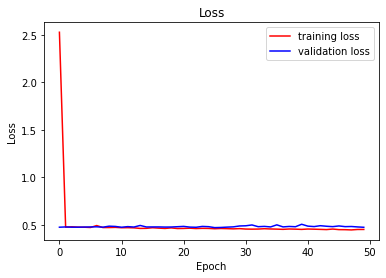

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(50)]
train_loss = np.log(loss_stats['train'])
val_loss = np.log(loss_stats['val'])
plt.plot(x, train_loss, color = 'red', label='training loss')
plt.plot(x, val_loss, color = 'blue', label='validation loss')
plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Loss")  # add Y-axis label
plt.title("Loss")  # add title
plt.legend()
plt.savefig('loss.png')

plt.show()

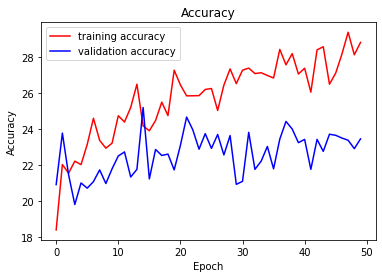

In [ ]:
x = [i for i in range(50)]
train_acc = accuracy_stats['train']
val_acc = accuracy_stats['val']
plt.plot(x, train_acc, color = 'red', label='training accuracy')
plt.plot(x, val_acc, color = 'blue', label='validation accuracy')
plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Accuracy")  # add Y-axis label
plt.title("Accuracy")  # add title
plt.legend()
plt.savefig('accu.png')

plt.show()

DenseNet

In [ ]:
"""
	The Network Class
"""

import torch
import torch.nn as nn
import math

class Dense_Block(nn.Module):
	def __init__(self, in_channels):
		super(Dense_Block, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = in_channels)

		self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

    
	def forward(self, x):

		bn = self.bn(x)
		conv1 = self.relu(self.conv1(bn))

		conv2 = self.relu(self.conv2(conv1))
		c2_dense = self.relu(torch.cat([conv1, conv2], 1))

		conv3 = self.relu(self.conv3(c2_dense))
		c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

		conv4 = self.relu(self.conv4(c3_dense))
		c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

		conv5 = self.relu(self.conv5(c4_dense))
		c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

		return c5_dense


class Transition_Layer(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNet(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNet, self).__init__()

		self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.relu = nn.ReLU()

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
# import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# # from Model import CNN
# # from Dataset import CatsAndDogsDataset
from tqdm import tqdm
import torchvision.models as models

# device = ("cuda" if torch.cuda.is_available() else "cpu")


# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import time
import torch.optim as optim
# import torch.optim as optim
from torch.autograd import Variable
# GPU flag
use_gpu = torch.cuda.is_available()


transform = transforms.Compose(
        [
            # transforms.Resize((512, 512)),
            transforms.Resize((256, 256)),
            # transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
# num_epochs = 50
# learning_rate = 0.001
# train_CNN = False
# batch_size = 16
# shuffle = True
# pin_memory = True
# num_workers = 1

# Hyperparameters
batch_size = 10
momentum = 0.95
# learning_rate = 0.05

learning_rate = 1e-3
# wd = 1e-6

nr_classes = 5
nr_epochs = 20
loss_vctr = []
num_workers = 1
shuffle = True
pin_memory = True
# Load the model on the GPU
# densenet = DenseNet(nr_classes)
densenet = models.densenet169(pretrained=True)



if use_gpu:
  densenet.cuda()


dataset = DiabeticRetinopathy("/content/merge_folder","filtered_annotations.csv",transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset,[2800,700])
classes = (0, 1, 2, 3, 4)

trainloader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
testloader = DataLoader(dataset=test_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)


start = time.time()

# Oprimization Criteria and Optimization method
criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=momentum, nesterov = False)
# optimizer = optim.Adam(densenet.parameters(),lr=learning_rate,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

# Training Loop
print("Start of the Optimization Processs..")
for epoch in range(nr_epochs):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs).cuda() 
        labels = labels.long()
        labels = Variable(labels).cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            loss_vctr.append(running_loss / 20)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    
print("^^^^^^^^^^^^^^^^^")
print('Finished Optimization.')
end = time.time() # Time counted in seconds
print("The total time to train the model on the K80 GPU is : {:.1f} minutes.".format((end - start)/60))

Start of the Optimization Processs..
[1,    20] loss: 4.938
[1,    40] loss: 1.875
[1,    60] loss: 1.798
[1,    80] loss: 1.748
[1,   100] loss: 1.722
[1,   120] loss: 1.536
[1,   140] loss: 1.625
[1,   160] loss: 1.671
[1,   180] loss: 1.595
[1,   200] loss: 1.387
[1,   220] loss: 1.398
[1,   240] loss: 1.273
[1,   260] loss: 1.315
[1,   280] loss: 1.448
[2,    20] loss: 1.274
[2,    40] loss: 1.418
[2,    60] loss: 1.476
[2,    80] loss: 1.235
[2,   100] loss: 1.415
[2,   120] loss: 1.403
[2,   140] loss: 1.422
[2,   160] loss: 1.313
[2,   180] loss: 1.315
[2,   200] loss: 1.350
[2,   220] loss: 1.232
[2,   240] loss: 1.315
[2,   260] loss: 1.238
[2,   280] loss: 1.305
[3,    20] loss: 1.134
[3,    40] loss: 1.211
[3,    60] loss: 1.251
[3,    80] loss: 1.333
[3,   100] loss: 1.199
[3,   120] loss: 1.293
[3,   140] loss: 1.158
[3,   160] loss: 1.207
[3,   180] loss: 1.245
[3,   200] loss: 1.218
[3,   220] loss: 1.415
[3,   240] loss: 1.311
[3,   260] loss: 1.315
[3,   280] loss: 1.2

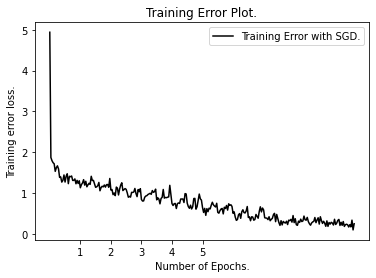

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = range(280)
x_epoch = [z for z in range(1, 141) if z%28 == 0] 
x_ticks_labels = [str(x) for x in range(1, 11)]

plt.figure(1)
plt.plot(x, loss_vctr, color = 'k', label = "Training Error with SGD.")
plt.xticks(x_epoch, x_ticks_labels)
plt.title("Training Error Plot.")
plt.ylabel("Training error loss.")
plt.xlabel("Number of Epochs.")
plt.legend()
# plt.savefig("training_plot.png", dpi = 300)  If you want to save your plot, uncomment.
plt.show()


In [ ]:
!pip install numba



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [ ]:
correct = 0
total = 0

for data in testloader:
        
        images, labels = data
        # print(labels)
        images = Variable(images).cuda()
        outputs = densenet(images)
        _, predicted = torch.max(outputs.cpu().data, 1)
        # print(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum()

print(total)
print(correct) 
print('Accuracy of the network on the 700 test images: %d %%' % (
    100 * correct / total))


700
tensor(334)
Accuracy of the network on the 700 test images: 47 %


In [ ]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = densenet(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        # print(labels)
        # print(c)
        for i in range(10):
          # print(c[i])
          try:
            if c[i].item() == True:
              class_correct[int(labels[i].item())] += 1
            class_total[int(labels[i].item())] += 1
          except:
            pass
       



for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))